# HackUPC: HP Inventory Forecasting

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import boxcox
from statsmodels.api import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.utils import diff_inv

%matplotlib inline
warnings.filterwarnings("ignore")
sns.set(rc = {'figure.figsize': (5, 3)})
plt.style.use("fivethirtyeight")
rand_val = 765

In [3]:
path = 'data/'

In [4]:
df = pd.read_csv(f'{path}train.csv')

In [5]:
df.head()

id        date  year_week  product_number  reporterhq_id  \
0  202119-6909  2021-05-15     202119            6909             93   
1  202120-6909  2021-05-22     202120            6909             93   
2  202121-6909  2021-05-29     202121            6909             93   
3  202122-6909  2021-06-05     202122            6909             93   
4  202123-6909  2021-06-12     202123            6909             93   

  prod_category  specs  display_size  segment  sales_units  inventory_units  
0         Arale  21274          13.3  Premium          2.0             35.0  
1         Arale  21274          13.3  Premium          0.0             70.0  
2         Arale  21274          13.3  Premium          3.0            137.0  
3         Arale  21274          13.3  Premium          0.0            274.0  
4         Arale  21274          13.3  Premium          0.0            333.0

In [6]:
df.shape

(15454, 11)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15454 entries, 0 to 15453
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15454 non-null  object 
 1   date             15454 non-null  object 
 2   year_week        15454 non-null  int64  
 3   product_number   15454 non-null  int64  
 4   reporterhq_id    15454 non-null  int64  
 5   prod_category    15454 non-null  object 
 6   specs            15454 non-null  int64  
 7   display_size     15454 non-null  float64
 8   segment          15454 non-null  object 
 9   sales_units      14963 non-null  float64
 10  inventory_units  14961 non-null  float64
dtypes: float64(3), int64(4), object(4)
memory usage: 1.3+ MB


In [8]:
df.loc[(pd.isna(df.sales_units)) | (pd.isna(df.inventory_units))].sort_values(by = ['year_week']).head(25)

id        date  year_week  product_number  reporterhq_id  \
13482  201919-233919  2019-05-11     201919          233919              3   
13487  201921-233919  2019-05-25     201921          233919             24   
13498  201927-233919  2019-07-06     201927          233919              3   
13521  201938-233919  2019-09-21     201938          233919             24   
13520  201938-233919  2019-09-21     201938          233919              3   
13552  202002-233919  2020-01-11     202002          233919              3   
13564  202008-233919  2020-02-22     202008          233919              3   
14145  202016-235893  2020-04-18     202016          235893             24   
13584  202018-233919  2020-05-02     202018          233919              3   
14160  202031-235893  2020-08-01     202031          235893             24   
13613  202032-233919  2020-08-08     202032          233919             24   
13626  202039-233919  2020-09-26     202039          233919              3   
14177  202048-235893  2020-11-28     202048          235893             24   
15153  202049-247737  2020-12-05     202049          247737             24   
13663  202104-233919  2021-01-30     202104          233919             24   
468      202108-9870  2021-02-27     202108            9870             12   
469      202109-9870  2021-03-06     202109            9870             12   
13677  202111-233919  2021-03-20     202111          233919             24   
13920  202112-234906  2021-03-27     202112          234906             12   
980     202113-12831  2021-04-03     202113           12831             12   
13684  202115-233919  2021-04-17     202115          233919              3   
2043    202116-32571  2021-04-24     202116           32571             24   
15195  202117-247737  2021-05-01     202117          247737             24   
14741  202119-239841  2021-05-15     202119          239841             93   
630     202120-10857  2021-05-22     202120           10857             12   

      prod_category   specs  display_size  segment  sales_units  \
13482        Clover  106370          15.6     Core         10.0   
13487        Clover  106370          15.6     Core          NaN   
13498        Clover  106370          15.6     Core         91.0   
13521        Clover  106370          15.6     Core          NaN   
13520        Clover  106370          15.6     Core          NaN   
13552        Clover  106370          15.6     Core          NaN   
13564        Clover  106370          15.6     Core         36.0   
14145        Clover   50284          17.3     Core          1.0   
13584        Clover  106370          15.6     Core          NaN   
14160        Clover   50284          17.3     Core          8.0   
13613        Clover  106370          15.6     Core          1.0   
13626        Clover  106370          15.6     Core          NaN   
14177        Clover   50284          17.3     Core          NaN   
15153         Arale   10637          13.3  Premium          3.0   
13663        Clover  106370          15.6     Core          0.0   
468        Doraemon  107337          15.6   Gaming         21.0   
469        Doraemon  107337          15.6   Gaming          NaN   
13677        Clover  106370          15.6     Core          NaN   
13920          Goku  111205          15.6   Gaming          0.0   
980        Doraemon  180829          15.6   Gaming          NaN   
13684        Clover  106370          15.6     Core          NaN   
2043         Clover  221443          15.6     Core          NaN   
15195         Arale   10637          13.3  Premium          NaN   
14741          Goku   95733          15.6     Core          NaN   
630        Doraemon  108304          15.6   Gaming          NaN   

       inventory_units  
13482              NaN  
13487            214.0  
13498              NaN  
13521             57.0  
13520             63.0  
13552             25.0  
13564              NaN  
14145              NaN  
13584              1.

In [9]:
df.loc[(pd.isna(df.sales_units)) & (pd.isna(df.inventory_units))].sort_values(by = ['year_week']).head(25)

id        date  year_week  product_number  reporterhq_id  \
1468    202124-24675  2021-06-19     202124           24675             24   
10645  202208-187530  2022-02-26     202208          187530             78   
12859  202225-221088  2022-06-25     202225          221088             78   
3533    202236-51324  2022-09-10     202236           51324             21   
4341    202244-64155  2022-11-05     202244           64155             12   
3569    202249-51324  2022-12-10     202249           51324             15   
9534   202313-167790  2023-04-01     202313          167790             24   
2030    202317-30597  2023-04-29     202317           30597              3   

      prod_category   specs  display_size  segment  sales_units  \
1468          Conan    4835          13.3  Premium          NaN   
10645        Bobobo  142149          16.1   Gaming          NaN   
12859      Doraemon   37713          16.1   Gaming          NaN   
3533           Goku  168258          15.6     Core          NaN   
4341         Clover  121842          14.0     Core          NaN   
3569           Goku  168258          15.6     Core          NaN   
9534           Goku   58987          17.3   Gaming          NaN   
2030         Clover  195334          15.6     Core          NaN   

       inventory_units  
1468               NaN  
10645              NaN  
12859              NaN  
3533               NaN  
4341               NaN  
3569               NaN  
9534               NaN  
2030               NaN

In [10]:
df = df.loc[~(pd.isna(df.sales_units)) | ~(pd.isna(df.inventory_units))].sort_values(by = ['year_week'])

- We have about 976 nulls from sales_units and inventory_units
- 8 cases where both are null, and 968 where only one of them are null
- Wont drop for now, as we might be able to interpolate

In [11]:
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

In [12]:
df['week'] = df['year_week'].astype('str').str[-2:]
df['year'] = df['year_week'].astype('str').str[:-2]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15446 entries, 13476 to 15453
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               15446 non-null  object        
 1   date             15446 non-null  datetime64[ns]
 2   year_week        15446 non-null  int64         
 3   product_number   15446 non-null  int64         
 4   reporterhq_id    15446 non-null  int64         
 5   prod_category    15446 non-null  object        
 6   specs            15446 non-null  int64         
 7   display_size     15446 non-null  float64       
 8   segment          15446 non-null  object        
 9   sales_units      14963 non-null  float64       
 10  inventory_units  14961 non-null  float64       
 11  week             15446 non-null  object        
 12  year             15446 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(5)
memory usage: 1.6+ MB


In [14]:
df.describe()

year_week  product_number  reporterhq_id          specs  \
count   15446.000000    15446.000000   15446.000000   15446.000000   
mean   202240.709828   127208.491130      42.146057  112262.589732   
std        61.598909    77502.438142      34.912978   63618.986014   
min    201915.000000     6909.000000       3.000000     967.000000   
25%    202218.000000    58233.000000      15.000000   58987.000000   
50%    202239.000000   116466.000000      24.000000  109271.000000   
75%    202304.000000   196413.000000      78.000000  157621.000000   
max    202318.000000   247737.000000      96.000000  236915.000000   

       display_size   sales_units  inventory_units  
count  15446.000000  14963.000000     14961.000000  
mean      15.163395     25.974938        71.726222  
std        1.422477     29.392055        66.145326  
min       11.000000      0.000000         0.000000  
25%       14.000000      3.000000        26.000000  
50%       15.600000     16.000000        56.000000  
75%       15.600000     38.000000        97.000000  
max       17.300000    186.000000       399.000000

In [15]:
print(f'\nTotal number of unique products: {len(df.product_number.unique())}')
print(f'\nTotal number of unique product categories: {len(df.prod_category.unique())}')
print(f'\nTotal number of unique segments: {len(df.segment.unique())}')
print(f'\nTotal number of unique weeks: {len(df.week.unique())}')
print(f'\nTotal number of unique years: {len(df.year.unique())}')


Total number of unique products: 100

Total number of unique product categories: 7

Total number of unique segments: 3

Total number of unique weeks: 53

Total number of unique years: 5


In [16]:
prod_freq = df.groupby(['product_number'])['id'].count().reset_index().rename(columns = {'id': 'count'}).sort_values(by = 'count', ascending = False)

prod_freq.product_number = prod_freq.product_number.astype('str')

In [17]:
fig = px.bar(
    prod_freq, 
    x = 'product_number', 
    y = 'count',
    title = 'Product Frequency'
)

fig.show()

In [18]:
prod_cat_freq = df.groupby(['prod_category'])['id'].count().reset_index().rename(columns = {'id': 'count'}).sort_values(by = 'count', ascending = False)

In [19]:
fig = px.bar(
    prod_cat_freq, 
    x = 'prod_category', 
    y = 'count',
    title = 'Product Category Frequency'
)

fig.show()

In [20]:
segment_freq = df.groupby(['segment'])['id'].count().reset_index().rename(columns = {'id': 'count'}).sort_values(by = 'count', ascending = False)

In [21]:
fig = px.bar(
    segment_freq, 
    x = 'segment', 
    y = 'count',
    title = 'Segment Frequency'
)

fig.show()

In [22]:
venders_per_product = df[['product_number', 'reporterhq_id']].drop_duplicates().groupby(['product_number'])['reporterhq_id'].count(
).reset_index().rename(columns = {'reporterhq_id': 'count'}).sort_values(by = 'count', ascending = False)

venders_per_product.product_number = venders_per_product.product_number.astype('str')

In [23]:
fig = px.bar(
    venders_per_product, 
    x = 'product_number', 
    y = 'count',
    title = 'Vendors per product'
)

fig.show()

In [24]:
week = df.groupby(['week'])['id'].count().reset_index().rename(columns = {'id': 'count'}).sort_values(by = 'week', ascending = True)

In [25]:
fig = px.bar(
    week, 
    x = 'week', 
    y = 'count',
    title = 'Tuple frequency by week'
)

fig.show()

In [26]:
year = df.groupby(['year'])['id'].count().reset_index().rename(columns = {'id': 'count'}).sort_values(by = 'year', ascending = True)

In [27]:
fig = px.bar(
    year, 
    x = 'year', 
    y = 'count',
    title = 'Tuple frequency by year'
)

fig.show()

In [28]:
year_ex_vendors = df[['id', 'date', 'product_number', 'year']].drop_duplicates().groupby(['year'])['id'].count().reset_index().rename(columns = {'id': 'count'}).sort_values(by = 'year', ascending = True)

In [29]:
fig = px.bar(
    year_ex_vendors, 
    x = 'year', 
    y = 'count',
    title = 'Tuple frequency by year (eliminating multiple vendors)'
)

fig.show()

In [30]:
df.year = df.year.astype('int32')
df = df.loc[df.year >= 2021]

In [31]:
df2 = df.copy()

# do laplace addition to deal with 0 inventory unit cases
df2['sales_inv_ratio'] = (df2['sales_units'] + 1) / (df2['inventory_units'] + 1)
df2 = df2[['date', 'product_number', 'reporterhq_id', 'sales_inv_ratio']]

In [32]:
df2_agg = df2[['product_number', 'reporterhq_id', 'sales_inv_ratio']].groupby(['product_number', 'reporterhq_id'])['sales_inv_ratio'].count(
).reset_index().rename(columns = {'sales_inv_ratio': 'count'}).sort_values(
    by = ['product_number', 'count'], ascending = False
)

In [33]:
df2_agg['vendor'] = df2_agg.sort_values(['product_number','count'], ascending = [True,False]).groupby(['product_number']).cumcount() + 1

In [34]:
df2a = df2.merge(
    df2_agg,
    how = 'inner',
    left_on = ['product_number', 'reporterhq_id'],
    right_on = ['product_number', 'reporterhq_id']
)

df2a = df2a[['date', 'product_number', 'vendor', 'sales_inv_ratio']]

In [35]:
df2_pivot = pd.pivot_table(df2a, index = ['date', 'product_number'], columns = 'vendor', fill_value = np.nan, values = 'sales_inv_ratio'
).reset_index().reset_index(drop = True)

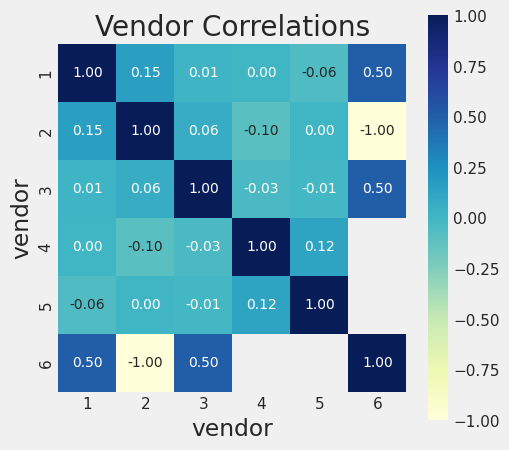

In [36]:
df2_pivot_corr = df2_pivot[[1, 2, 3, 4, 5, 6]].corr(method = 'spearman')
plt.figure(figsize = (5, 5))
sns.heatmap(df2_pivot_corr, annot = True, annot_kws = {'size': 10}, square = True, cmap = 'YlGnBu', fmt = '.2f').set(title = 'Vendor Correlations')
plt.show()

In [37]:
df2_pivot_b = df2_pivot[['product_number', 1, 2]].dropna()

In [38]:
product_list = df2_pivot_b.product_number.unique().tolist()
corr_list = []

for product in product_list:
    corr_list.append(df2_pivot_b.loc[df2_pivot_b.product_number == product].corr()[1][2])
    
# nan
del corr_list[-32]

In [39]:
sum(corr_list) / len(corr_list)

0.045288962345584494

In [40]:
fig = px.line(
    df2.loc[df.product_number == 10857], 
    x = 'date', 
    y = 'sales_inv_ratio',
    color = 'reporterhq_id',
    title = 'Specific Product: Sales over time'
)

fig.show()

In [41]:
# fig = px.line(
#     df.loc[df.segment == 'Core'], 
#     x = 'date', 
#     y = 'sales_units',
#     color = 'reporterhq_id',
#     title = 'Specific Product: Sales over time'
# )

# fig.show()

In [42]:
fig = px.bar(
    df.groupby(['prod_category'])['specs'].mean().reset_index().sort_values(by = 'specs', ascending = False), 
    x = 'prod_category', 
    y = 'specs',
    title = 'Product Cat & Specs'
)

fig.show()

In [43]:
fig = px.bar(
    df.groupby(['prod_category'])['display_size'].mean().reset_index().sort_values(by = 'display_size', ascending = False), 
    x = 'prod_category', 
    y = 'display_size',
    title = 'Product Cat & display_size'
)

fig.show()

In [44]:
fig = px.bar(
    df.groupby(['segment'])['specs'].mean().reset_index().sort_values(by = 'specs', ascending = False), 
    x = 'segment', 
    y = 'specs',
    title = 'Segment & Specs'
)

fig.show()

In [45]:
fig = px.bar(
    df.groupby(['segment'])['display_size'].mean().reset_index().sort_values(by = 'display_size', ascending = False), 
    x = 'segment', 
    y = 'display_size',
    title = 'segment & display_size'
)

fig.show()

In [46]:
fig = px.scatter(
    df, 
    x = 'specs', 
    y = 'display_size',
    color = 'prod_category',
    title = ''
)

fig.show()

In [47]:
fig = px.scatter(
    df, 
    x = 'specs', 
    y = 'sales_units',
    color = 'prod_category',
    title = ''
)

fig.show()

In [48]:
sales_inv = df.groupby(['product_number', 'prod_category', 'segment'])['sales_units', 'inventory_units'].median().reset_index()

In [49]:
fig = px.scatter(
    sales_inv, 
    x = 'sales_units', 
    y = 'inventory_units',
    color = 'prod_category',
    title = 'With Product Categories'
)

fig.update_layout(
    height = 650,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.update_traces(
    marker = dict(
        size = 8,
        line = dict(
            width = 1,
            color = 'Black'
        )
    ),
    selector=dict(mode='markers')
)

fig.show()

In [50]:
sales_inv_array = sales_inv[['sales_units', 'inventory_units']].values

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0df28a2ca0>
Traceback (most recent call last):
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

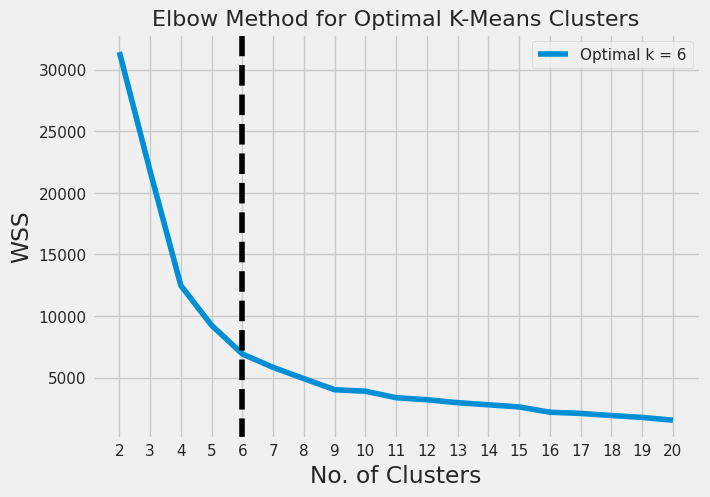

In [51]:
from sklearn.cluster import KMeans
from kneed import KneeLocator

# apply the elbow method to check the 'Within Sum of Squared Distance' and identify the the optimal k clusters to use

wss = []
n = 21

for k in range(2, n):
    kmeans = KMeans(n_clusters = k, random_state = rand_val, n_init = 'auto')
    kmeans.fit(sales_inv_array)
    wss.append(kmeans.inertia_)
    
kl = KneeLocator(range(2, n), wss, curve = 'convex', direction = 'decreasing')
elbow = kl.elbow

plt.figure(figsize = (7, 5))
plt.plot(range(2, n), wss, label = f'Optimal k = {elbow}')
plt.xticks(range(2, n))
plt.axvline(x = elbow, color = 'black', linestyle = '--')
plt.title('Elbow Method for Optimal K-Means Clusters', size = 16)
plt.xlabel("No. of Clusters")
plt.ylabel("WSS")
plt.legend()
plt.show()

In [52]:
# Use the optimal k for applying k-means clustering to the data and have a new column with the assigned clusters

kmeans_model = KMeans(n_clusters = elbow, random_state = rand_val)
sales_inv['cluster'] = kmeans_model.fit_predict(sales_inv_array)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0df2930dc0>
Traceback (most recent call last):
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

In [53]:
sales_inv.head()

product_number prod_category  segment  sales_units  inventory_units  \
0            6909         Arale  Premium          2.0             30.0   
1            7896          Goku     Core          7.0             67.0   
2            8883          Goku     Core          8.0             62.0   
3            9870      Doraemon   Gaming         12.5             73.0   
4           10857      Doraemon   Gaming         10.0             51.0   

   cluster  
0        3  
1        0  
2        0  
3        1  
4        2

In [54]:
# import plotly.io as pio
# pio.templates.default = "plotly_white"

fig = px.scatter(
    sales_inv, 
    x = 'sales_units', 
    y = 'inventory_units',
    color = 'cluster',
    title = 'With new clusters'
)

fig.update_layout(
    height = 650,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.update_traces(
    marker = dict(
        size = 8,
        line = dict(
            width = 1,
            color = 'Black'
        )
    ),
    selector=dict(mode='markers')
)

fig.show()

In [55]:
df3 = df.merge(
    sales_inv,
    how = 'inner',
    left_on = 'product_number',
    right_on = 'product_number'
)[['date', 'product_number', 'reporterhq_id', 'cluster', 'sales_units_x', 'inventory_units_x']]

df3.rename(columns = {'sales_units_x': 'sales_units', 'inventory_units_x': 'inventory_units'}, inplace = True)

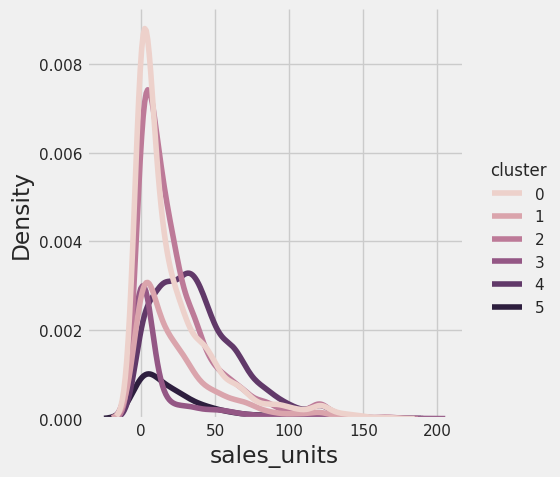

In [56]:
sns.displot(data = df3, x = "sales_units", hue = "cluster", kind = "kde")

In [57]:
fig = px.line(
    df.groupby(['date', 'prod_category'])['sales_units'].median().reset_index(), 
    x = 'date', 
    y = 'sales_units',
    color = 'prod_category',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [58]:
fig = px.line(
    df3.groupby(['date', 'cluster'])['sales_units'].median().reset_index(), 
    x = 'date', 
    y = 'sales_units',
    color = 'cluster',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [59]:
fig = px.line(
    df.groupby(['date', 'prod_category'])['inventory_units'].median().reset_index(), 
    x = 'date', 
    y = 'inventory_units',
    color = 'prod_category',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [60]:
fig = px.line(
    df3.groupby(['date', 'cluster'])['inventory_units'].median().reset_index(), 
    x = 'date', 
    y = 'inventory_units',
    color = 'cluster',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [61]:
fig = px.line(
    df.groupby(['date', 'prod_category'])['sales_units'].sum().reset_index(), 
    x = 'date', 
    y = 'sales_units',
    color = 'prod_category',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [62]:
fig = px.line(
    df3.groupby(['date', 'cluster'])['sales_units'].sum().reset_index(), 
    x = 'date', 
    y = 'sales_units',
    color = 'cluster',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [63]:
fig = px.line(
    df.groupby(['date', 'prod_category'])['inventory_units'].sum().reset_index(), 
    x = 'date', 
    y = 'inventory_units',
    color = 'prod_category',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [64]:
fig = px.line(
    df3.groupby(['date', 'cluster'])['inventory_units'].sum().reset_index(), 
    x = 'date', 
    y = 'inventory_units',
    color = 'cluster',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [65]:
fig = px.line(
    df.groupby(['date', 'segment'])['sales_units'].sum().reset_index(), 
    x = 'date', 
    y = 'sales_units',
    color = 'segment',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [66]:
sales_inv

product_number prod_category  segment  sales_units  inventory_units  \
0             6909         Arale  Premium          2.0             30.0   
1             7896          Goku     Core          7.0             67.0   
2             8883          Goku     Core          8.0             62.0   
3             9870      Doraemon   Gaming         12.5             73.0   
4            10857      Doraemon   Gaming         10.0             51.0   
..             ...           ...      ...          ...              ...   
95          238854          Goku     Core          8.0             62.0   
96          239841          Goku     Core          7.0             57.5   
97          240828         Conan  Premium          9.5            125.0   
98          242802         Conan  Premium          9.5             54.0   
99          247737         Arale  Premium         19.0             28.0   

    cluster  
0         3  
1         0  
2         0  
3         1  
4         2  
..      ...  
95        0  
96        0  
97        5  
98        0  
99        2  

[100 rows x 6 columns]

In [67]:
fig = px.scatter(
    sales_inv, 
    x = 'sales_units', 
    y = 'inventory_units',
    color = 'segment',
    title = 'With Segments'
)

fig.update_layout(
    height = 650,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.update_traces(
    marker = dict(
        size = 8,
        line = dict(
            width = 1,
            color = 'Black'
        )
    ),
    selector=dict(mode='markers')
)

fig.show()

<AxesSubplot: xlabel='sales_units', ylabel='Density'>

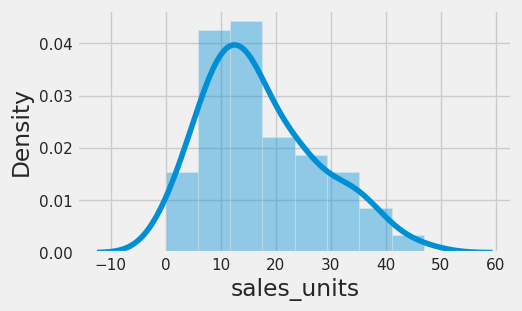

In [68]:
sns.distplot(sales_inv.sales_units)

<AxesSubplot: xlabel='inventory_units', ylabel='Density'>

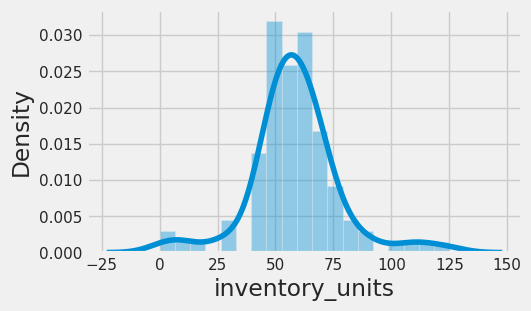

In [69]:
sns.distplot(sales_inv.inventory_units)

In [70]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [71]:
from sklearn.mixture import GaussianMixture
from sklearn import metrics

n_clusters=np.arange(2, 11)
sils=[]
sils_err=[]
iterations=20
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=2).fit(sales_inv_array) 
        labels=gmm.predict(sales_inv_array)
        sil=metrics.silhouette_score(sales_inv_array, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0e30e011f0>
Traceback (most recent call last):
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

Text(0, 0.5, 'Score')

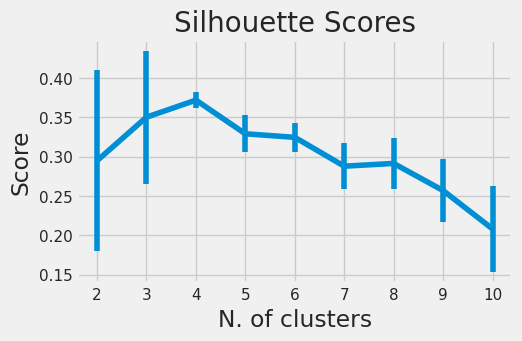

In [72]:
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

In [73]:
gmm = GaussianMixture(n_components = 4).fit(sales_inv_array)
sales_inv['gmm_cluster'] = gmm.predict(sales_inv_array)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0e30dd8550>
Traceback (most recent call last):
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

In [74]:
fig = px.scatter(
    sales_inv, 
    x = 'sales_units', 
    y = 'inventory_units',
    color = 'gmm_cluster',
    title = 'With gmm clusters'
)

fig.update_layout(
    height = 650,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.update_traces(
    marker = dict(
        size = 8,
        line = dict(
            width = 1,
            color = 'Black'
        )
    ),
    selector=dict(mode='markers')
)

fig.show()

In [75]:
df4 = df.merge(
    sales_inv,
    how = 'inner',
    left_on = 'product_number',
    right_on = 'product_number'
)[['date', 'product_number', 'reporterhq_id', 'gmm_cluster', 'sales_units_x', 'inventory_units_x']]

df4.rename(columns = {'sales_units_x': 'sales_units', 'inventory_units_x': 'inventory_units'}, inplace = True)

In [76]:
fig = px.line(
    df4.groupby(['date', 'gmm_cluster'])['inventory_units'].sum().reset_index(), 
    x = 'date', 
    y = 'inventory_units',
    color = 'gmm_cluster',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [77]:
fig = px.line(
    df4.groupby(['date', 'gmm_cluster'])['sales_units'].sum().reset_index(), 
    x = 'date', 
    y = 'sales_units',
    color = 'gmm_cluster',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [78]:
fig = px.line(
    df4.groupby(['date', 'gmm_cluster'])['inventory_units'].median().reset_index(), 
    x = 'date', 
    y = 'inventory_units',
    color = 'gmm_cluster',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [79]:
fig = px.line(
    df4.groupby(['date', 'gmm_cluster'])['sales_units'].median().reset_index(), 
    x = 'date', 
    y = 'sales_units',
    color = 'gmm_cluster',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [80]:
sales_inv

product_number prod_category  segment  sales_units  inventory_units  \
0             6909         Arale  Premium          2.0             30.0   
1             7896          Goku     Core          7.0             67.0   
2             8883          Goku     Core          8.0             62.0   
3             9870      Doraemon   Gaming         12.5             73.0   
4            10857      Doraemon   Gaming         10.0             51.0   
..             ...           ...      ...          ...              ...   
95          238854          Goku     Core          8.0             62.0   
96          239841          Goku     Core          7.0             57.5   
97          240828         Conan  Premium          9.5            125.0   
98          242802         Conan  Premium          9.5             54.0   
99          247737         Arale  Premium         19.0             28.0   

    cluster  gmm_cluster  
0         3            0  
1         0            2  
2         0            2  
3         1            2  
4         2            2  
..      ...          ...  
95        0            2  
96        0            2  
97        5            3  
98        0            2  
99        2            0  

[100 rows x 7 columns]

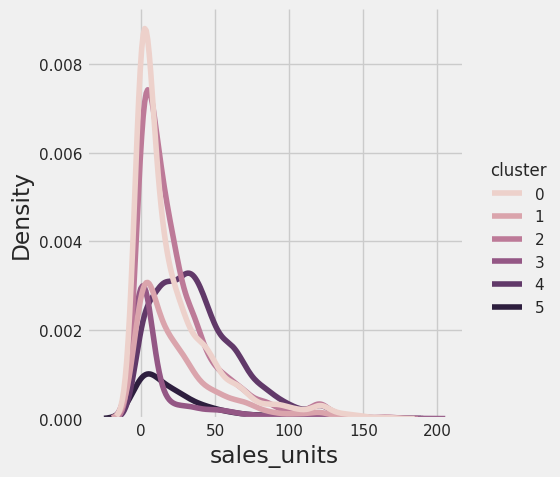

In [81]:
sns.displot(data = df3, x = "sales_units", hue = "cluster", kind = "kde")

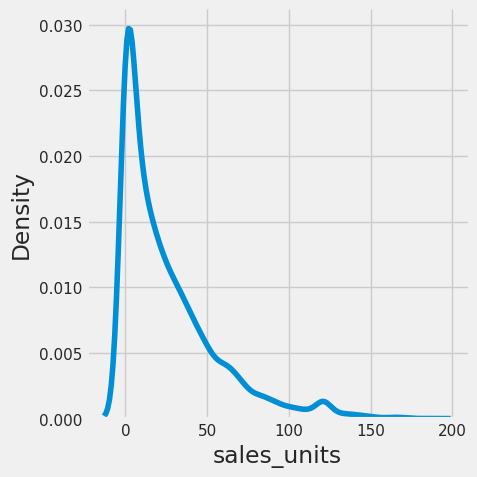

In [82]:
sns.displot(data = df3, x = "sales_units", kind = "kde")

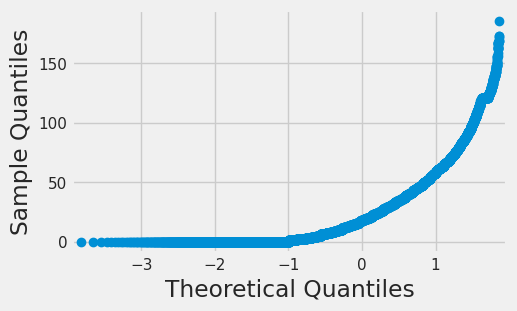

In [83]:
qqplot(df3['sales_units'], line = 's')
plt.show()

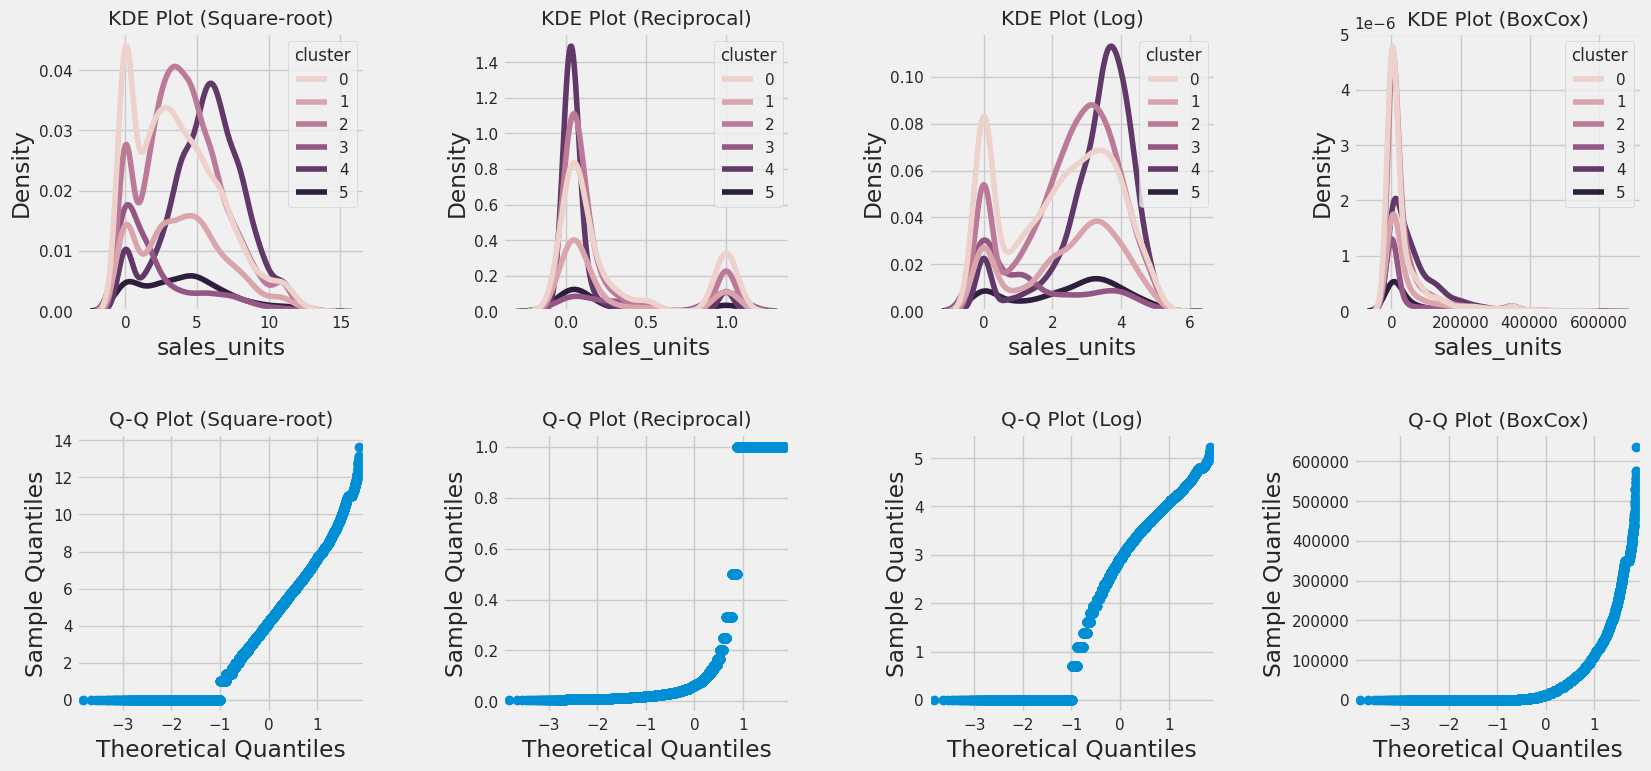

In [84]:
fig, ax = plt.subplots(2, 4, figsize = (18, 9), squeeze = True)
fig.tight_layout(pad = 5)
plt.rcParams['font.size'] = '10'

# square-root transformation
df_transform = df3.copy()
df_transform.sales_units = np.sqrt(df_transform.sales_units)
sns.kdeplot(data = df_transform, x = "sales_units", hue = "cluster", ax = ax[0][0])
ax[0][0].set(title = 'KDE Plot (Square-root)')
qqplot(df_transform['sales_units'], line = 's', ax = ax[1][0])
ax[1][0].set(title = 'Q-Q Plot (Square-root)')

# # reciprocal transformation
df_transform = df3.copy()
df_transform.sales_units = (1 / (np.array(df_transform.sales_units) + 1))
sns.kdeplot(data = df_transform, x = "sales_units", hue = "cluster", ax = ax[0][1])
ax[0][1].set(title = 'KDE Plot (Reciprocal)')
qqplot(df_transform['sales_units'], line = 's', ax = ax[1][1])
ax[1][1].set(title = 'Q-Q Plot (Reciprocal)')

# # log transformation
df_transform = df3.copy()
df_transform.sales_units = np.log(np.array(df_transform.sales_units) + 1)
sns.kdeplot(data = df_transform, x = "sales_units", hue = "cluster", ax = ax[0][2])
ax[0][2].set(title = 'KDE Plot (Log)')
qqplot(df_transform['sales_units'], line = 's', ax = ax[1][2])
ax[1][2].set(title = 'Q-Q Plot (Log)')

# # boxcox transformation
df_transform = df3.copy()
df_transform.sales_units = np.log(np.array(df_transform.sales_units) + 1)
df_transform['sales_units'], bc_lambda = boxcox((df_transform['sales_units'] + 1).values)
sns.kdeplot(data = df_transform, x = "sales_units", hue = "cluster", ax = ax[0][3])
ax[0][3].set(title = 'KDE Plot (BoxCox)')
qqplot(df_transform['sales_units'], line = 's', ax = ax[1][3])
ax[1][3].set(title = 'Q-Q Plot (BoxCox)', )


plt.show()

In [85]:
df_transform = df.copy()
df_transform.sales_units = np.log(np.array(df_transform.sales_units) + 1)
df_transform.inventory_units = np.log(np.array(df_transform.inventory_units) + 1)
df_transform.rename(columns = {'sales_units': 'log_sales', 'inventory_units': 'log_inventory'}, inplace = True)

In [86]:
df_transform.head()

id       date  year_week  product_number  reporterhq_id  \
972     202101-12831 2021-01-09     202101           12831             12   
14183  202101-235893 2021-01-09     202101          235893             24   
13657  202101-233919 2021-01-09     202101          233919             24   
13656  202101-233919 2021-01-09     202101          233919              3   
781     202101-11844 2021-01-09     202101           11844             12   

      prod_category   specs  display_size segment  log_sales  log_inventory  \
972        Doraemon  180829          15.6  Gaming   2.197225       3.931826   
14183        Clover   50284          17.3    Core   3.091042       3.806662   
13657        Clover  106370          15.6    Core   0.000000       0.000000   
13656        Clover  106370          15.6    Core   1.098612       0.000000   
781        Doraemon  109271          15.6  Gaming   3.496508       3.258097   

      week  year  
972     01  2021  
14183   01  2021  
13657   01  2021  
13656   01  2021  
781     01  2021

In [87]:
fig = px.line(
    df_transform.loc[df_transform.product_number == 10857], 
    x = 'date', 
    y = 'log_sales',
    color = 'reporterhq_id',
    title = 'Specific Product: Sales over time'
)

fig.show()

In [88]:
df_transform_final = df_transform.merge(
    sales_inv,
    how = 'inner',
    left_on = 'product_number',
    right_on = 'product_number'
)[['id', 'date', 'year_week', 'product_number', 'reporterhq_id', 'prod_category_x', 'specs', 'display_size', 'segment_x', 'log_sales', 'log_inventory', 'week', 'year', 'cluster', 'gmm_cluster']]

df_transform_final.rename(
    columns = {
        'prod_category_x': 'prod_category',
        'segment_x': 'segment',
        'cluster': 'km_cluster'
    },
    inplace = True
)

In [89]:
df_transform_final.head()

id       date  year_week  product_number  reporterhq_id  \
0  202101-12831 2021-01-09     202101           12831             12   
1  202102-12831 2021-01-16     202102           12831             12   
2  202103-12831 2021-01-23     202103           12831             12   
3  202108-12831 2021-02-27     202108           12831             12   
4  202109-12831 2021-03-06     202109           12831             12   

  prod_category   specs  display_size segment  log_sales  log_inventory week  \
0      Doraemon  180829          15.6  Gaming   2.197225       3.931826   01   
1      Doraemon  180829          15.6  Gaming   4.143135       4.543295   02   
2      Doraemon  180829          15.6  Gaming   4.753590       4.330733   03   
3      Doraemon  180829          15.6  Gaming   2.484907       4.644391   08   
4      Doraemon  180829          15.6  Gaming   4.290459       4.094345   09   

   year  km_cluster  gmm_cluster  
0  2021           0            2  
1  2021           0            2  
2  2021           0            2  
3  2021           0            2  
4  2021           0            2

In [90]:
vector_list = df_transform_final[['year', 'week', 'specs', 'display_size', 'log_sales', 'log_inventory', 'km_cluster']]

In [91]:
vector_list = vector_list.join(pd.get_dummies(vector_list.km_cluster, prefix = 'km_cluster'))
vector_list.drop(columns = ['km_cluster'], inplace = True)

In [92]:
vector_list.head()

year week   specs  display_size  log_sales  log_inventory  km_cluster_0  \
0  2021   01  180829          15.6   2.197225       3.931826             1   
1  2021   02  180829          15.6   4.143135       4.543295             1   
2  2021   03  180829          15.6   4.753590       4.330733             1   
3  2021   08  180829          15.6   2.484907       4.644391             1   
4  2021   09  180829          15.6   4.290459       4.094345             1   

   km_cluster_1  km_cluster_2  km_cluster_3  km_cluster_4  km_cluster_5  
0             0             0             0             0             0  
1             0             0             0             0             0  
2             0             0             0             0             0  
3             0             0             0             0             0  
4             0             0             0             0             0

In [93]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
vector_list = pd.DataFrame(scaler.fit_transform(vector_list), columns = vector_list.columns)
vector_list.head()

year      week     specs  display_size  log_sales  log_inventory  \
0   0.0  0.000000  0.762295      0.730159   0.420030       0.656238   
1   0.0  0.019608  0.762295      0.730159   0.792018       0.758295   
2   0.0  0.039216  0.762295      0.730159   0.908716       0.722817   
3   0.0  0.137255  0.762295      0.730159   0.475025       0.775168   
4   0.0  0.156863  0.762295      0.730159   0.820182       0.683363   

   km_cluster_0  km_cluster_1  km_cluster_2  km_cluster_3  km_cluster_4  \
0           1.0           0.0           0.0           0.0           0.0   
1           1.0           0.0           0.0           0.0           0.0   
2           1.0           0.0           0.0           0.0           0.0   
3           1.0           0.0           0.0           0.0           0.0   
4           1.0           0.0           0.0           0.0           0.0   

   km_cluster_5  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0

In [94]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors = 5)
knn_result = pd.DataFrame(imputer.fit_transform(vector_list), columns = vector_list.columns)

In [95]:
knn_result

year      week     specs  display_size  log_sales  log_inventory  \
0       0.0  0.000000  0.762295      0.730159   0.420030       0.656238   
1       0.0  0.019608  0.762295      0.730159   0.792018       0.758295   
2       0.0  0.039216  0.762295      0.730159   0.908716       0.722817   
3       0.0  0.137255  0.762295      0.730159   0.475025       0.775168   
4       0.0  0.156863  0.762295      0.730159   0.820182       0.683363   
...     ...       ...       ...           ...        ...            ...   
15171   1.0  0.313725  0.872951      0.730159   0.504493       0.659479   
15172   1.0  0.333333  0.872951      0.730159   0.622831       0.623832   
15173   1.0  0.333333  0.872951      0.730159   0.679655       0.768622   
15174   1.0  0.333333  0.872951      0.730159   0.000000       0.578446   
15175   1.0  0.333333  0.872951      0.730159   0.420030       0.713793   

       km_cluster_0  km_cluster_1  km_cluster_2  km_cluster_3  km_cluster_4  \
0               1.0           0.0           0.0           0.0           0.0   
1               1.0           0.0           0.0           0.0           0.0   
2               1.0           0.0           0.0           0.0           0.0   
3               1.0           0.0           0.0           0.0           0.0   
4               1.0           0.0           0.0           0.0           0.0   
...             ...           ...           ...           ...           ...   
15171           0.0           1.0           0.0           0.0           0.0   
15172           0.0           1.0           0.0           0.0           0.0   
15173           0.0           1.0           0.0           0.0           0.0   
15174           0.0           1.0           0.0           0.0           0.0   
15175           0.0           1.0           0.0           0.0           0.0   

       km_cluster_5  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  
...             ...  
15171           0.0  
15172           0.0  
15173           0.0  
15174           0.0  
15175           0.0  

[15176 rows x 12 columns]

In [96]:
knn_result = pd.DataFrame(scaler.inverse_transform(knn_result), columns = knn_result.columns)
knn_result.head()

year  week     specs  display_size  log_sales  log_inventory  \
0  2021.0   1.0  180829.0          15.6   2.197225       3.931826   
1  2021.0   2.0  180829.0          15.6   4.143135       4.543295   
2  2021.0   3.0  180829.0          15.6   4.753590       4.330733   
3  2021.0   8.0  180829.0          15.6   2.484907       4.644391   
4  2021.0   9.0  180829.0          15.6   4.290459       4.094345   

   km_cluster_0  km_cluster_1  km_cluster_2  km_cluster_3  km_cluster_4  \
0           1.0           0.0           0.0           0.0           0.0   
1           1.0           0.0           0.0           0.0           0.0   
2           1.0           0.0           0.0           0.0           0.0   
3           1.0           0.0           0.0           0.0           0.0   
4           1.0           0.0           0.0           0.0           0.0   

   km_cluster_5  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0

In [97]:
df_transform_final = df_transform_final[['id', 'date', 'year_week', 'product_number', 'reporterhq_id', 'km_cluster', 'gmm_cluster']].merge(
    knn_result,
    how = 'inner',
    left_index = True,
    right_index = True
).drop(columns = ['km_cluster_0', 'km_cluster_1', 'km_cluster_2', 'km_cluster_3', 'km_cluster_4', 'km_cluster_5'])

In [98]:
df_transform_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15176 entries, 0 to 15175
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              15176 non-null  object        
 1   date            15176 non-null  datetime64[ns]
 2   year_week       15176 non-null  int64         
 3   product_number  15176 non-null  int64         
 4   reporterhq_id   15176 non-null  int64         
 5   km_cluster      15176 non-null  int32         
 6   gmm_cluster     15176 non-null  int64         
 7   year            15176 non-null  float64       
 8   week            15176 non-null  float64       
 9   specs           15176 non-null  float64       
 10  display_size    15176 non-null  float64       
 11  log_sales       15176 non-null  float64       
 12  log_inventory   15176 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int32(1), int64(4), object(1)
memory usage: 2.1+ MB


In [99]:
fig = px.line(
    df_transform.loc[df_transform.product_number == 8883], 
    x = 'date', 
    y = 'log_sales',
    color = 'reporterhq_id',
    title = 'Specific Product: Sales over time (with missing data)'
)

fig.show()

In [100]:
fig = px.line(
    df_transform_final.loc[df_transform_final.product_number == 8883], 
    x = 'date', 
    y = 'log_sales',
    color = 'reporterhq_id',
    title = 'Specific Product: Sales over time (with imputation)'
)

fig.show()

In [101]:
fig = px.line(
    df_transform_final.loc[df_transform_final.product_number == 8883], 
    x = 'date', 
    y = 'log_inventory',
    color = 'reporterhq_id',
    title = 'Specific Product: Inventory over time'
)

fig.show()

In [102]:
df_transform_final = df_transform_final.groupby([
    'id', 'date', 'year_week', 
    'product_number', 'km_cluster', 'gmm_cluster', 
    'year', 'week', 'specs', 'display_size']
)['log_sales', 'log_inventory'].sum().reset_index()

In [103]:
df_transform_final

id       date  year_week  product_number  km_cluster  \
0      202101-11844 2021-01-09     202101           11844           0   
1      202101-12831 2021-01-09     202101           12831           0   
2     202101-233919 2021-01-09     202101          233919           3   
3     202101-235893 2021-01-09     202101          235893           3   
4     202101-247737 2021-01-09     202101          247737           2   
...             ...        ...        ...             ...         ...   
7528   202318-92778 2023-05-06     202318           92778           2   
7529   202318-93765 2023-05-06     202318           93765           2   
7530   202318-94752 2023-05-06     202318           94752           1   
7531    202318-9870 2023-05-06     202318            9870           1   
7532   202318-99687 2023-05-06     202318           99687           2   

      gmm_cluster    year  week     specs  display_size  log_sales  \
0               2  2021.0   1.0  109271.0          15.6   3.496508   
1               2  2021.0   1.0  180829.0          15.6   2.197225   
2               0  2021.0   1.0  106370.0          15.6   1.098612   
3               0  2021.0   1.0   50284.0          17.3   3.091042   
4               0  2021.0   1.0   10637.0          13.3   5.730100   
...           ...     ...   ...       ...           ...        ...   
7528            1  2023.0  18.0  140215.0          14.0   5.863631   
7529            1  2023.0  18.0  155687.0          14.0   6.194405   
7530            3  2023.0  18.0  224344.0          14.0   6.918206   
7531            2  2023.0  18.0  107337.0          15.6   2.397895   
7532            2  2023.0  18.0  227245.0          15.6   6.708084   

      log_inventory  
0          3.258097  
1          3.931826  
2          0.000000  
3          3.806662  
4          2.197225  
...             ...  
7528       7.749349  
7529       4.499810  
7530      12.011444  
7531       7.601902  
7532      12.662991  

[7533 rows x 12 columns]

In [104]:
fig = px.line(
    df3.groupby(['date', 'cluster'])['sales_units'].median().reset_index(), 
    x = 'date', 
    y = 'sales_units',
    color = 'cluster',
    title = 'Sales without transformation & imputation'
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [105]:
fig = px.line(
    df_transform_final.groupby(['date', 'km_cluster'])['log_sales'].median().reset_index(), 
    x = 'date', 
    y = 'log_sales',
    color = 'km_cluster',
    title = 'Sales with log transformation, knn-imputation & vendor aggregation'
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

---

## Timeseries Forecasting

In [106]:
df_transform_final.head()

id       date  year_week  product_number  km_cluster  \
0   202101-11844 2021-01-09     202101           11844           0   
1   202101-12831 2021-01-09     202101           12831           0   
2  202101-233919 2021-01-09     202101          233919           3   
3  202101-235893 2021-01-09     202101          235893           3   
4  202101-247737 2021-01-09     202101          247737           2   

   gmm_cluster    year  week     specs  display_size  log_sales  log_inventory  
0            2  2021.0   1.0  109271.0          15.6   3.496508       3.258097  
1            2  2021.0   1.0  180829.0          15.6   2.197225       3.931826  
2            0  2021.0   1.0  106370.0          15.6   1.098612       0.000000  
3            0  2021.0   1.0   50284.0          17.3   3.091042       3.806662  
4            0  2021.0   1.0   10637.0          13.3   5.730100       2.197225

In [107]:
clusters = df_transform_final.groupby(['date', 'km_cluster'])['log_sales', 'log_inventory'].mean().reset_index()
clusters.head()

date  km_cluster  log_sales  log_inventory
0 2021-01-09           0   2.846866       3.594961
1 2021-01-09           1   4.262680       4.369448
2 2021-01-09           2   5.730100       2.197225
3 2021-01-09           3   2.094827       1.903331
4 2021-01-16           0   3.863327       4.090440

In [108]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=clusters.loc[clusters.km_cluster == 0].date, y=clusters.loc[clusters.km_cluster == 0].log_sales,
                    mode='lines',
                    name='Log Sales'))
fig.add_trace(go.Scatter(x=clusters.loc[clusters.km_cluster == 0].date, y=clusters.loc[clusters.km_cluster == 0].log_inventory,
                    mode='lines',
                    name='Log Inventory'))

fig.update_layout(
    height = 500,
    title = 'Cluster 0',
    coloraxis = dict( colorscale = 'Spectral')
)


fig.show()

In [109]:
weights = df_transform_final.merge(
    clusters,
    how = 'inner',
    left_on = ['date', 'km_cluster'],
    right_on = ['date', 'km_cluster']
)

In [110]:
weights['log_sales_weight'] = weights['log_sales_y'] - weights['log_sales_x']
weights['log_inventory_weight'] = weights['log_inventory_y'] - weights['log_inventory_x']

In [111]:
weights_final = weights.groupby(['product_number', 'km_cluster'])['log_sales_weight', 'log_inventory_weight'].median().reset_index()

In [112]:
weights_final

product_number  km_cluster  log_sales_weight  log_inventory_weight
0             6909           3          0.227301             -0.633828
1             7896           0          1.373445              1.431886
2             8883           0          0.689804             -0.033070
3             9870           1          0.230652              0.587999
4            10857           2          1.673762              1.499322
..             ...         ...               ...                   ...
95          238854           0          1.132377              1.410133
96          239841           0          1.015764              1.260919
97          240828           5          1.683803              3.297274
98          242802           0          0.842703              1.246807
99          247737           2         -2.049183             -0.875346

[100 rows x 4 columns]

## Serious time

In [113]:
clusters.loc[clusters.km_cluster == 0].drop(columns = ['km_cluster', 'log_sales']).set_index('date')[-13:]

log_inventory
date                     
2023-02-11      10.637323
2023-02-18      10.366539
2023-02-25      10.950022
2023-03-04      10.731946
2023-03-11      11.389060
2023-03-18      11.179037
2023-03-25      11.244443
2023-04-01      11.019258
2023-04-08      10.856298
2023-04-15      10.809332
2023-04-22      11.022562
2023-04-29      11.282870
2023-05-06      11.225554

In [114]:
ts = clusters.loc[clusters.km_cluster == 0].drop(columns = ['km_cluster', 'log_sales']).set_index('date')
ts_train = ts[:-13]
ts_test = ts[-13:]

In [115]:
ts_train.head()

log_inventory
date                     
2021-01-09       3.594961
2021-01-16       4.090440
2021-01-23       4.131279
2021-01-30       3.850148
2021-02-06       3.988984

In [116]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = ts_train.index, y = ts_train.log_inventory,
                    mode = 'lines',
                    name = 'Log Inventory'))

fig.update_layout(
    height = 500,
    title = 'Cluster 0: Log Inventory',
    coloraxis = dict( colorscale = 'Spectral')
)


fig.show()

In [117]:
def run_adf_test(ts):
    result = adfuller(ts)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [118]:
run_adf_test(ts)

ADF Statistic: 0.319258
p-value: 0.978211


In [119]:
diff_ts = ts_train.diff().dropna()

In [120]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = diff_ts.index, y = diff_ts.log_inventory,
                    mode = 'lines',
                    name = 'Log Inventory'))

fig.update_layout(
    height = 500,
    title = 'Cluster 0: Log Inventory (First differencing)',
    coloraxis = dict( colorscale = 'Spectral')
)


fig.show()

In [121]:
run_adf_test(diff_ts)

ADF Statistic: -5.442267
p-value: 0.000003


In [122]:
sdiff_ts = diff_ts.diff().dropna()

In [123]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = sdiff_ts.index, y = sdiff_ts.log_inventory,
                    mode = 'lines',
                    name = 'Log Inventory'))

fig.update_layout(
    height = 500,
    title = 'Cluster 0: Log Inventory (Second differencing)',
    coloraxis = dict( colorscale = 'Spectral')
)


fig.show()

In [124]:
run_adf_test(sdiff_ts)

ADF Statistic: -5.831988
p-value: 0.000000


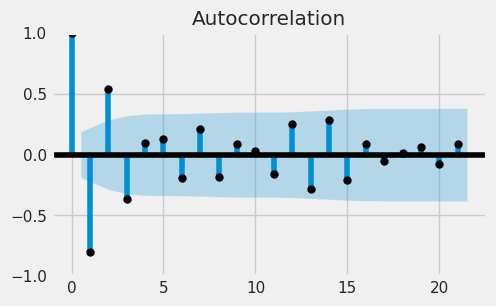

In [125]:
plot_acf(sdiff_ts, color = 'black')
plt.show()

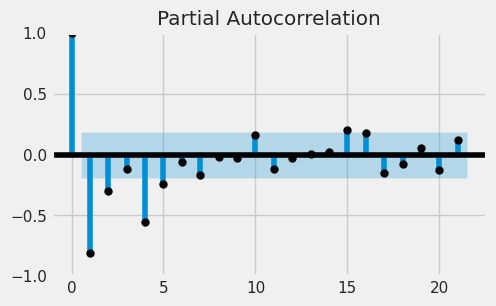

In [126]:
plot_pacf(sdiff_ts, color = 'black')
plt.show()

In [127]:
model = auto_arima(
    sdiff_ts,
    # d = 1,
    # D = 1,
    # m = 1,
    start_p = 0,
    max_p = 3,
    start_q = 0,
    max_q = 3,
    start_P = 0,
    max_P = 3,
    start_Q = 0,
    max_Q = 3,
    max_order = 6,
    trace = True,
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=414.338, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=295.893, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=412.355, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=291.125, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=289.601, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=287.604, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=289.132, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 1.308 seconds


In [128]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  107
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -139.802
Date:                Sun, 14 May 2023   AIC                            287.604
Time:                        01:19:26   BIC                            298.296
Sample:                    01-23-2021   HQIC                           291.939
                         - 02-04-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0851      0.057    -18.989      0.000      -1.197      -0.973
ar.L2         -0.4396      0.089     -4.935      0.000      -0.614      -0.265
ar.L3         -0.1949      0.073     -2.660      0.008      -0.338      -0.051
sigma2         0.7879      0.062     12.689      0.000       0.666       0.910
===================================================================================
Ljung-Box (L1) (Q):                   1.35   Jarque-Bera (JB):               118.70
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):              23.57   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

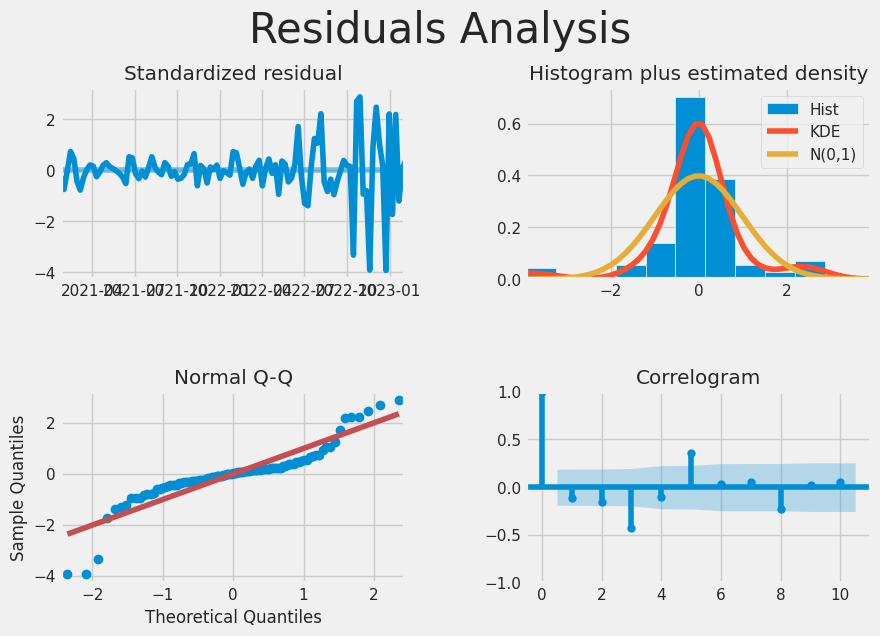

In [129]:
plt.rcParams.update({'figure.figsize': (10, 7)})
model.plot_diagnostics()
plt.tight_layout(pad = 5)
plt.suptitle('Residuals Analysis', fontsize = 30)
plt.show()

In [130]:
in_sample_preds = model.predict_in_sample(return_conf_int = False, dynamic = False)

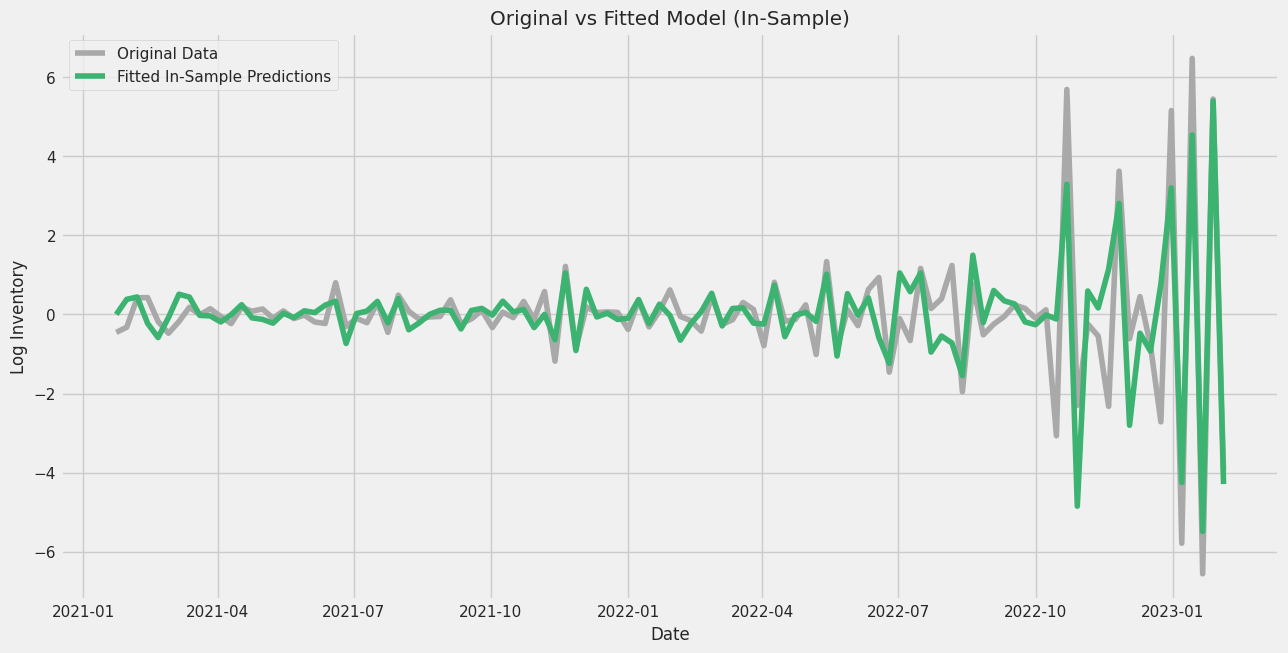

In [131]:
plt.rcParams.update({'figure.figsize': (14, 7)})
plt.plot(sdiff_ts, color = 'darkgrey', label = 'Original Data')
plt.plot(in_sample_preds, color = 'mediumseagreen', label = 'Fitted In-Sample Predictions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Log Inventory')
plt.title('Original vs Fitted Model (In-Sample)')
plt.show()

In [171]:
period = 13
fc, conf_int = model.predict(n_periods = period, return_conf_int = True, alpha = 0.05)

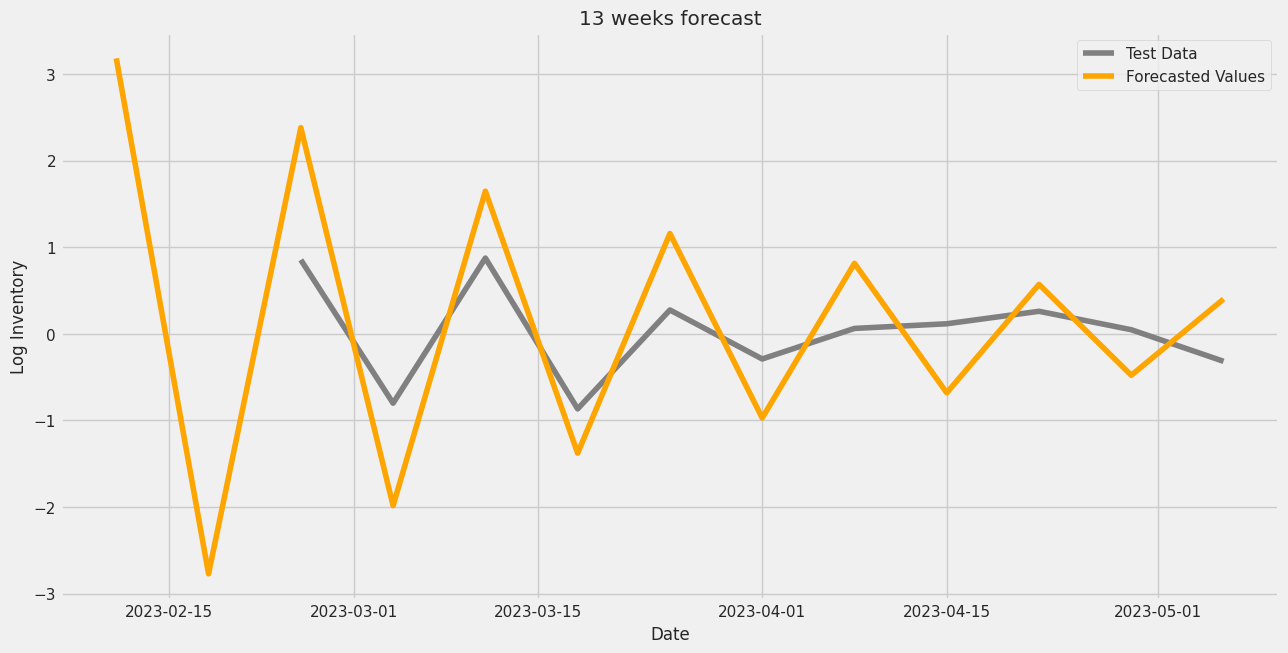

In [172]:
plt.plot(ts_test.diff().dropna().diff().dropna(), color = 'grey', label = 'Test Data')
plt.plot(fc, color = 'orange', label = 'Forecasted Values')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Log Inventory')
plt.title(f'13 weeks forecast')
plt.show()

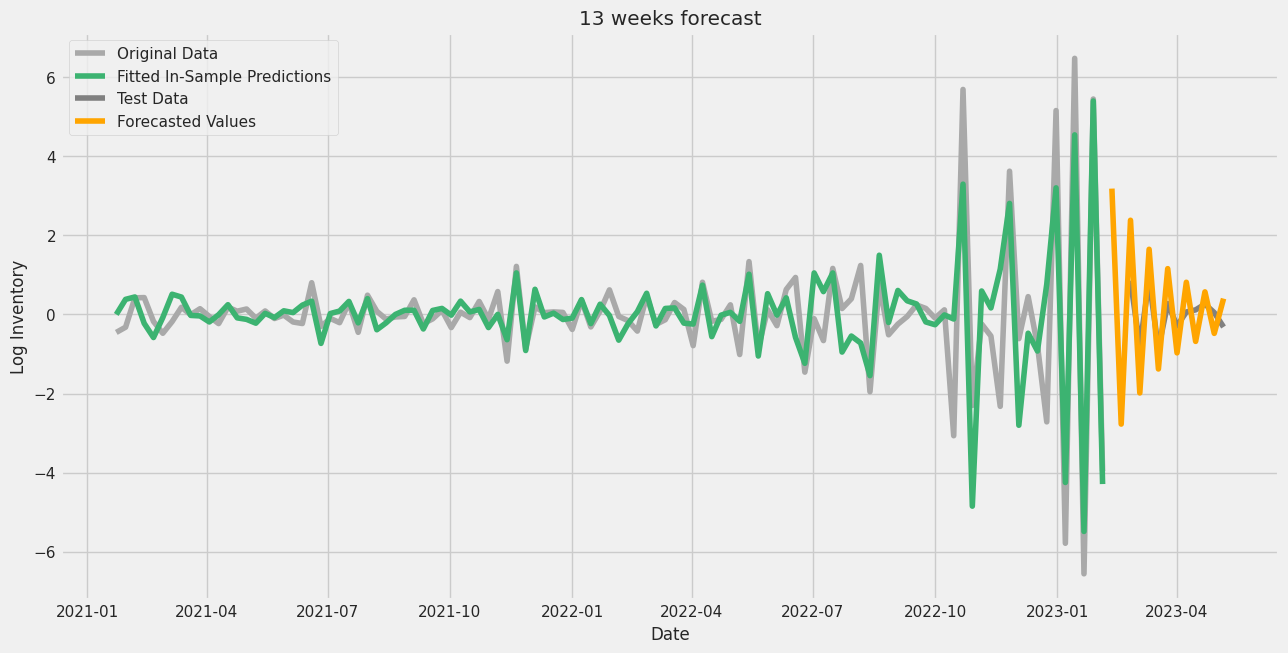

In [173]:
plt.plot(sdiff_ts, color = 'darkgrey', label = 'Original Data')
plt.plot(in_sample_preds, color = 'mediumseagreen', label = 'Fitted In-Sample Predictions')
plt.plot(ts_test.diff().dropna().diff().dropna(), color = 'grey', label = 'Test Data')
plt.plot(fc, color = 'orange', label = 'Forecasted Values')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Log Inventory')
plt.title(f'13 weeks forecast')
plt.show()

In [135]:
append = in_sample_preds[-2:]

In [136]:
# fc = pd.concat([append, fc])

In [174]:
fc = fc.to_frame().rename(columns = {0: 'forecast'})
fc

forecast
2023-02-11  3.182138
2023-02-18 -2.772480
2023-02-25  2.381362
2023-03-04 -1.985129
2023-03-11  1.647315
2023-03-18 -1.378749
2023-03-25  1.158641
2023-04-01 -0.972053
2023-04-08  0.814028
2023-04-15 -0.681699
2023-04-22  0.571229
2023-04-29 -0.478745
2023-05-06  0.401174

In [184]:
# ts_train.reset_index()[-1:]['log_inventory'].item()
diff_ts


log_inventory
date                     
2021-01-16       0.495479
2021-01-23       0.040839
2021-01-30      -0.281132
2021-02-06       0.138836
2021-02-13       0.564893
...                   ...
2023-01-07      -3.154141
2023-01-14       3.321292
2023-01-21      -3.237022
2023-01-28       2.210065
2023-02-04      -1.751815

[108 rows x 1 columns]

In [163]:
# def inv_diff (df_orig_column,df_diff_column, periods):
#     # Generate np.array for the diff_inv function - it includes first n values(n = 
#     # periods) of original data & further diff values of given periods
#     value = np.array(df_orig_column[:periods].tolist()+df_diff_column[periods:].tolist())

#     # Generate np.array with inverse diff
#     inv_diff_vals = diff_inv(value, periods,1 )[periods:]
#     return inv_diff_vals    

In [187]:

fc['forecast_cumsum'] = fc['forecast'].cumsum()
fc['first'] = fc['forecast_cumsum']+ diff_ts.reset_index()[-1:]['log_inventory'].item()
fc['first_cumsum'] = fc['first'].cumsum()
fc['second'] = fc['first_cumsum']+ ts_train.reset_index()[-1:]['log_inventory'].item()
fc


forecast  forecast_cumsum     first  first_cumsum    second
2023-02-11  3.182138         3.182138  1.430323      1.430323  9.875279
2023-02-18 -2.772480         0.409658 -1.342157      0.088166  8.533121
2023-02-25  2.381362         2.791020  1.039204      1.127370  9.572326
2023-03-04 -1.985129         0.805890 -0.945925      0.181445  8.626401
2023-03-11  1.647315         2.453205  0.701390      0.882835  9.327791
2023-03-18 -1.378749         1.074457 -0.677358      0.205477  8.650433
2023-03-25  1.158641         2.233097  0.481282      0.686759  9.131715
2023-04-01 -0.972053         1.261044 -0.490771      0.195988  8.640944
2023-04-08  0.814028         2.075072  0.323257      0.519245  8.964200
2023-04-15 -0.681699         1.393372 -0.358443      0.160802  8.605758
2023-04-22  0.571229         1.964602  0.212786      0.373589  8.818544
2023-04-29 -0.478745         1.485857 -0.265958      0.107630  8.552586
2023-05-06  0.401174         1.887031  0.135216      0.242846  8.687802

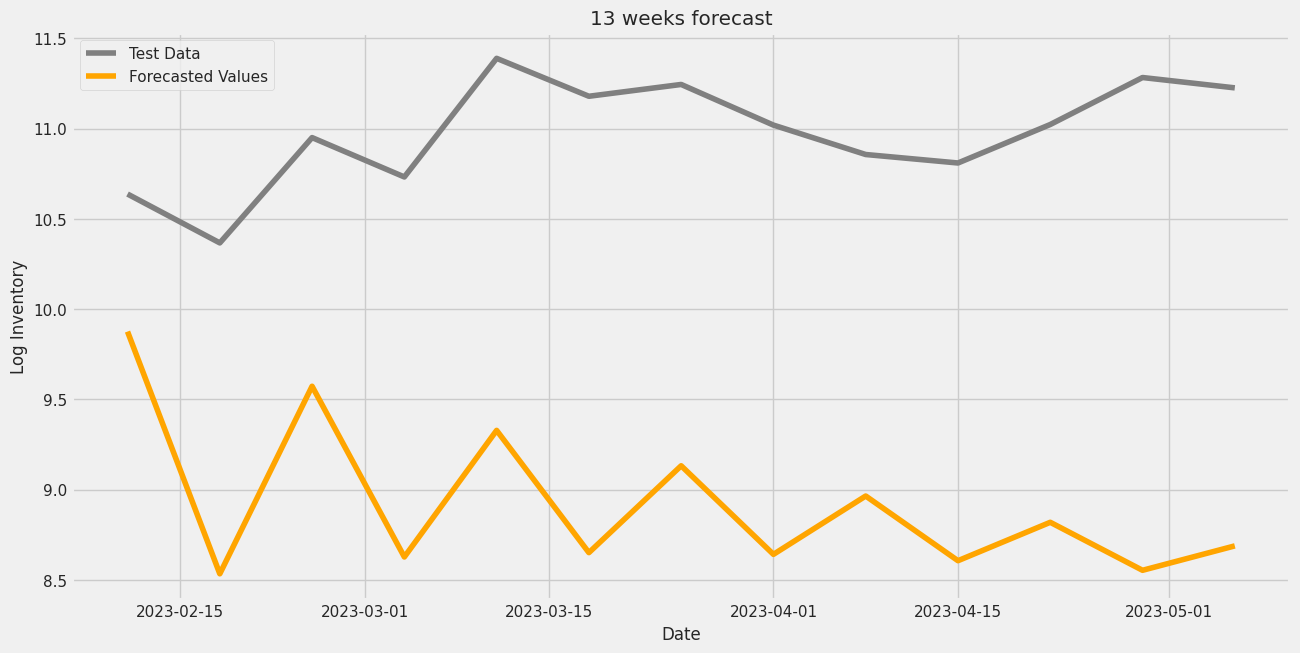

In [188]:
plt.plot(ts_test, color = 'grey', label = 'Test Data')
plt.plot(fc.second, color = 'orange', label = 'Forecasted Values')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Log Inventory')
plt.title(f'13 weeks forecast')
plt.show()

In [189]:
evaluation = fc.merge(
    ts_test,
    left_index = True,
    right_index = True
)

In [190]:
evaluation

forecast  forecast_cumsum     first  first_cumsum    second  \
2023-02-11  3.182138         3.182138  1.430323      1.430323  9.875279   
2023-02-18 -2.772480         0.409658 -1.342157      0.088166  8.533121   
2023-02-25  2.381362         2.791020  1.039204      1.127370  9.572326   
2023-03-04 -1.985129         0.805890 -0.945925      0.181445  8.626401   
2023-03-11  1.647315         2.453205  0.701390      0.882835  9.327791   
2023-03-18 -1.378749         1.074457 -0.677358      0.205477  8.650433   
2023-03-25  1.158641         2.233097  0.481282      0.686759  9.131715   
2023-04-01 -0.972053         1.261044 -0.490771      0.195988  8.640944   
2023-04-08  0.814028         2.075072  0.323257      0.519245  8.964200   
2023-04-15 -0.681699         1.393372 -0.358443      0.160802  8.605758   
2023-04-22  0.571229         1.964602  0.212786      0.373589  8.818544   
2023-04-29 -0.478745         1.485857 -0.265958      0.107630  8.552586   
2023-05-06  0.401174         1.887031  0.135216      0.242846  8.687802   

            log_inventory  
2023-02-11      10.637323  
2023-02-18      10.366539  
2023-02-25      10.950022  
2023-03-04      10.731946  
2023-03-11      11.389060  
2023-03-18      11.179037  
2023-03-25      11.244443  
2023-04-01      11.019258  
2023-04-08      10.856298  
2023-04-15      10.809332  
2023-04-22      11.022562  
2023-04-29      11.282870  
2023-05-06      11.225554

In [193]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(evaluation.log_inventory, evaluation.second, squared = False)

In [194]:
rmse

2.11631528256993

AttributeError: 'DataFrame' object has no attribute 'reverse_reverse_diff'

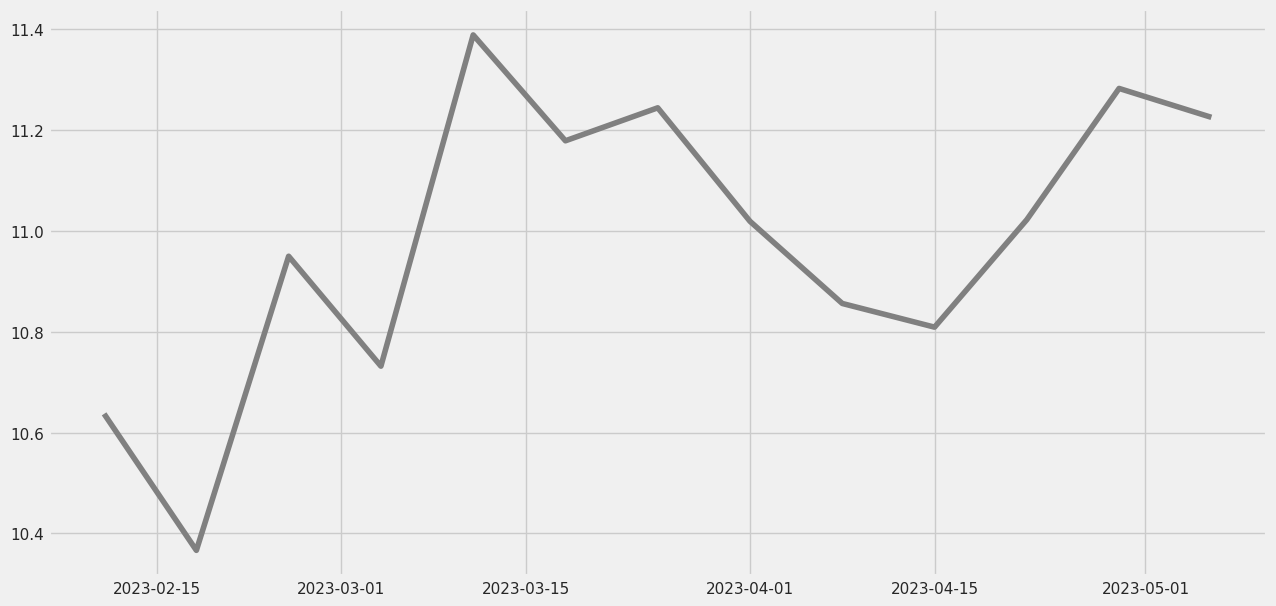

In [145]:
plt.plot(ts_test, color = 'grey', label = 'Test Data')
plt.plot(fc.reverse_reverse_diff, color = 'orange', label = 'Forecasted Values')
# plt.fill_between(forecast.index, lb, ub, color = 'orange', alpha = 0.05)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Log Inventory')
plt.title(f'13 weeks forecast')
plt.show()

In [ ]:
ts_test

log_inventory
date                     
2023-02-11      10.637323
2023-02-18      10.366539
2023-02-25      10.950022
2023-03-04      10.731946
2023-03-11      11.389060
2023-03-18      11.179037
2023-03-25      11.244443
2023-04-01      11.019258
2023-04-08      10.856298
2023-04-15      10.809332
2023-04-22      11.022562
2023-04-29      11.282870
2023-05-06      11.225554

In [ ]:
ts_test #.diff().dropna().diff().dropna()

log_inventory
date                     
2023-02-11      10.637323
2023-02-18      10.366539
2023-02-25      10.950022
2023-03-04      10.731946
2023-03-11      11.389060
2023-03-18      11.179037
2023-03-25      11.244443
2023-04-01      11.019258
2023-04-08      10.856298
2023-04-15      10.809332
2023-04-22      11.022562
2023-04-29      11.282870
2023-05-06      11.225554